# Create Data Vector: From Cosmosis Datablock

To validate and test the y3 cluster pipeline we make a simplified mock data where they are an output for a fixed cosmology and mor.

In [1]:
#!/usr/bin/env python
import os

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [2]:
# !pip3 install fitsio

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [4]:
kw = {
    'LogMass': r'log(M_{200c})',
    'R': r'$R$ [Mpc]',
    'DSigma': r'$\Delta \Sigma \;\; [M_{\odot}/pc^2]$',
    'Shear': r'\gamma_{T} \;'
}

In [5]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
const = 1.67e-7 * (0.3 * 0.7**2) # /Mpc^2
rhom = const/6.01e-19  # Msun/Mpc^2

cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [6]:
def get_block(model,col,dtype=None):
    return np.genfromtxt(root+'%s/%s.txt'%(model.lower(), col),dtype=dtype)

root = '/global/cfs/cdirs/des/jesteves/codes/fnalFall2022/mocks/mock/datablock_0/'
print(root)

/global/cfs/cdirs/des/jesteves/codes/fnalFall2022/mocks/mock/datablock_0/


## $\gamma_T$ Profiles

In [7]:
!ls /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/kappa/

errors.txt	ivol.txt      probs.txt   vals.txt
gridpoints.txt	nregions.txt  status.txt


In [8]:
_shear = get_block("kappa", "vals")
radii = get_block("kappa", "gridpoints")[:,2]
ncvals = get_block("numbercounts", "vals")
status = get_block("kappa", "status")#.astype(int)

# reshape
radii = radii[:int(radii.size/3)]
shear = _shear.reshape(4,3,radii.size)/ncvals[:,:,np.newaxis]

(0.2, 7.0)

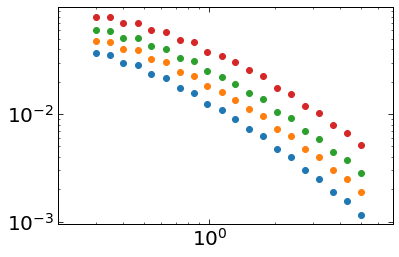

In [9]:
plt.loglog()
plt.scatter(radii, shear[0,0,:])
plt.scatter(radii, shear[1,0,:])
plt.scatter(radii, shear[2,0,:])
plt.scatter(radii, shear[3,0,:])
plt.xlim(0.2,7.)


There is a missing factor!

In [10]:
!ls /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/sigmacritinv/

r_sigma.txt  sigma_crit_inv.txt  z.txt


In [11]:
SCinv = get_block("sigmacritinv","sigma_crit_inv")[:,0]
zsc = get_block("sigmacritinv","z")

zbins = np.array([0.2,0.35,0.5,0.65])
zmed = 0.5*(zbins[1:]+zbins[:-1])
sigma_crit_inv = np.interp(zmed,zsc, SCinv)
dSigma = shear/sigma_crit_inv[np.newaxis,:,np.newaxis]

Text(0, 0.5, '\\gamma_{T} \\;')

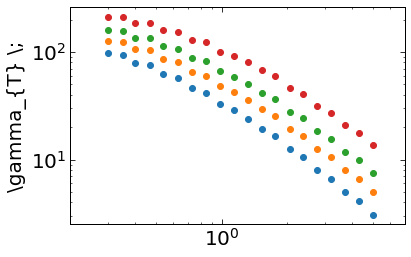

In [12]:
plt.loglog()
plt.scatter(radii, dSigma[0,0,:])
plt.scatter(radii, dSigma[1,0,:])
plt.scatter(radii, dSigma[2,0,:])
plt.scatter(radii, dSigma[3,0,:])
plt.xlim(0.2,7.)
plt.ylabel(kw['Shear'])

# Compare With Colossus

In [13]:
from colossus.cosmology import cosmology
h0=0.7
params = {'flat': True, 'H0': 100*h0, 'Om0': 0.3, 'Ob0': 0.045, 'sigma8': 0.83, 'ns': 0.96}
cosmology.addCosmology('myCosmo', **params)
cosmocol = cosmology.setCosmology('myCosmo')

In [14]:
from colossus.halo import profile_nfw
mass = 1e14
scol = profile_nfw.NFWProfile(M = mass, c = 4., z = 0, mdef = 'vir').deltaSigma(1000*radii)/(1e3**2)/h0

In [15]:
def duffy_concentration_relation(m_h, z_eff=0.4):
    a_eff = 1/(1+z_eff)
    m_h_pivot = 2e12
    return 7.85*np.power(m_h/m_h_pivot,-0.081)*np.power(a_eff,0.71)

In [16]:
from scipy.optimize import curve_fit
def fit_mass(radii, lgM):
    return profile_nfw.NFWProfile(M = 10**(lgM), c = 4., z = 0, mdef = 'vir').deltaSigma(1000*radii)/(1e3**2)/h0

def plot_fit(radii, dsigma, **kwargs):
    pars, _ = curve_fit(fit_mass, radii, dsigma, p0=[np.log10(1e14)])
    c = duffy_concentration_relation(10**pars[0])
    nfw = profile_nfw.NFWProfile(M = 10**(pars[0]), c = c, z = 0, mdef = 'vir').deltaSigma(1000*radii)/(1e3**2)/h0
    plt.plot(radii, nfw, **kwargs)
    print('Fitted log mass: %.2f'%pars[0])

In [17]:
label_zbins = ['%.2f < z < %.2f'%(zl,zh) for zl, zh in zip(zbins[:-1],zbins[1:])]
label_zbins

['0.20 < z < 0.35', '0.35 < z < 0.50', '0.50 < z < 0.65']

Redshift Bin 0
Fitted log mass: 13.87
Fitted log mass: 14.10
Fitted log mass: 14.28
Fitted log mass: 14.54

Redshift Bin 1
Fitted log mass: 13.85
Fitted log mass: 14.07
Fitted log mass: 14.26
Fitted log mass: 14.51

Redshift Bin 2
Fitted log mass: 13.90
Fitted log mass: 14.13
Fitted log mass: 14.32
Fitted log mass: 14.56



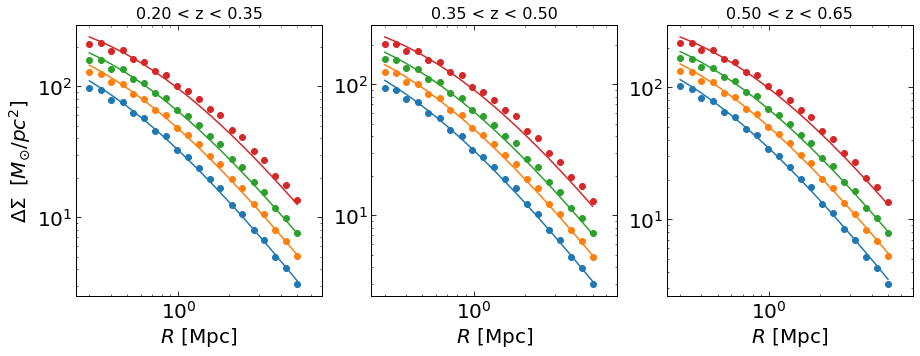

In [18]:
# print('Fixed Concentration 4')
plt.figure(figsize=(15,5))


for iz in range(3):
    print('Redshift Bin %i'%iz)
    plt.subplot(1,3,iz+1)
    plt.loglog()
    for i in range(4):
        plt.scatter(radii, dSigma[i,iz,:])
        plot_fit(radii, dSigma[i,iz,:])
    plt.xlim(0.25,7.)
    plt.xlabel(kw['R'])
    plt.title(label_zbins[iz], fontsize=16)
    if iz==0: 
        plt.ylabel(kw['DSigma'])
        #plt.legend()
    print()


In [19]:
!ls /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/

avgwp		      correlationfunction      mass_function	 shear
cdm_baryon_power_lin  cosmological_parameters  matter_power_lin  sigmacritinv
cdm_baryon_power_nl   distances		       matter_power_nl	 wp
cluster_abundance     growth_parameters        numbercounts
cmb_cl		      kappa		       recfast


In [ ]:
!less /global/common/software/des/jesteves/y3_cluster_cpp/y3_buzzard/datablock_0/cosmological_parameters/values.txt

a_s = 3.953989768081947e-09
baryon_fraction = 0.18181818181818182
cs2_de = 1.0
h0 = 0.6725999999999999
hubble = 67.25999999999999
k = -0.0
log1e10as = 3.97
massive_nu = 0
massless_nu = 3.046
mnu = 0.0
n_eff = 3.046
n_s = 0.975589
neutrino_hierarchy = 1
nnu = 3.046
num_massive_neutrinos = 3
num_nu_massive = 0
num_nu_massless = 3.046
ombh2 = 0.0180956304
omch2 = 0.0814303368
omega_b = 0.040000000000000015
omega_c = 0.18000000000000008
omega_k = 0.0
omega_lambda = 0.7799999999999999
pp/y3_buzzard/datablock_0/cosmological_parameters/values.txt lines 1-23/35 68%